# Titanic - Machine Learning from Disaster

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [50]:
data_train = pd.read_csv('data/train.csv')
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [51]:
data_y = data_train['Survived']

In [52]:
data_test = pd.read_csv('data/test.csv')
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Check data

In [53]:
data_test['test'] = True
data_train['test'] = False
data = pd.concat([data_train, data_test], axis=0)
data.isna().sum(axis=0)

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
test              0
dtype: int64

In [54]:
# sex 
data['SexBin'] = data['Sex'] == 1
data['SexBin'] = data['SexBin'].astype(int)

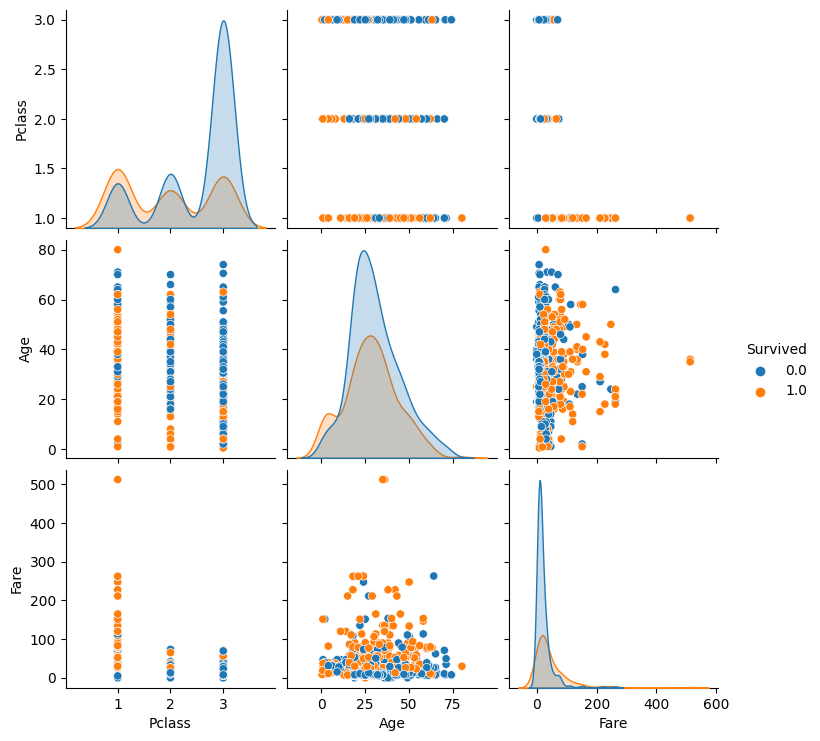

In [55]:
# dispertion graph by age, fare and Pclass
features = ['Survived', 'Pclass', 'Age', 'Fare']
sns.pairplot(data[data['test'] == False][features], hue='Survived') 
plt.show()

In [56]:
# check missing values
data.isna().sum(axis=0)

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
test              0
SexBin            0
dtype: int64

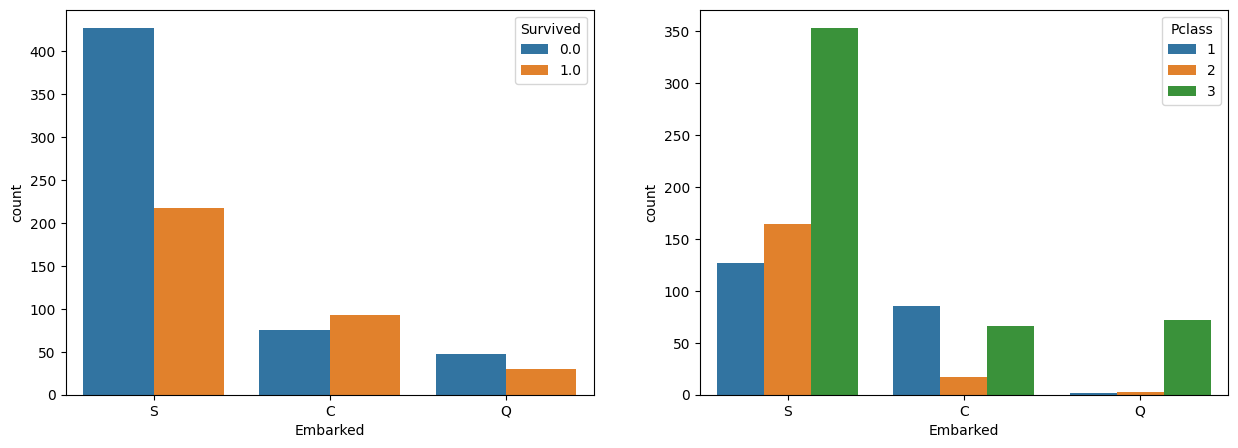

In [57]:
# Embarked
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x='Embarked', data=data[data['test'] == False], hue='Survived', ax=ax[0])
sns.countplot(x='Embarked', data=data[data['test'] == False], hue='Pclass', ax=ax[1])
plt.show()
data[data['Embarked'].isna()].head()
# fill missing values
data['Embarked'] = data['Embarked'].fillna('S')
embarked_map = {'S': 0, 'C': 1, 'Q': 2}
data['EmbarkedEncode'] = data['Embarked'].map(embarked_map)


In [58]:
# Fare
print(data[data['Fare'].isna()].head())
pclass3 = data[data['Pclass'] == 3]
data['Fare'].fillna(pclass3['Fare'].mean(), inplace=True)


     PassengerId  Survived  Pclass                Name   Sex   Age  SibSp  \
152         1044       NaN       3  Storey, Mr. Thomas  male  60.5      0   

     Parch Ticket  Fare Cabin Embarked  test  SexBin  EmbarkedEncode  
152      0   3701   NaN   NaN        S  True       0               0  


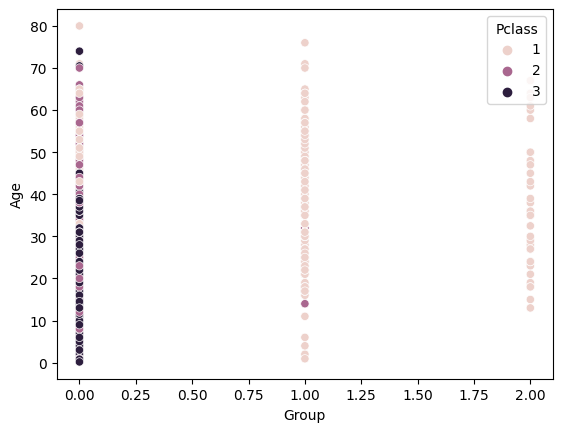

In [59]:
# Group data 
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, n_init=10)
# fare per person
data['FarePerPerson'] = data['Fare'] / (data['SibSp'] + data['Parch'] + 1)
data['FarePerClass'] = data['Fare'] / data['Pclass']
data['isAlone'] = (data['SibSp'] + data['Parch']) == 0
age_train = data[['Fare', 'Pclass',  'SibSp', 'Parch', 'SexBin', 'EmbarkedEncode', 'FarePerPerson', 'isAlone', 'FarePerClass']].dropna()

model.fit(age_train)
age_train['Group'] = model.predict(age_train)
age_train['Group'].value_counts(dropna=False)
data['Group'] = age_train['Group']
# graph
sns.scatterplot(x='Group', y='Age', data=data, hue='Pclass')
plt.show()

In [88]:
# Age
group_df = data.groupby('Group')['Age'].mean()
data['Age'] = data.apply(lambda x: group_df[x['Group']] if pd.isna(x['Age']) else x['Age'], axis=1)
data['GroupAge'] = pd.cut(data['Age'], bins=[0, 12, 18, 40, 60, 200], labels=["Child", "Teenager", "Adult", "MiddleAge", "Old"])
group_age_map = {'Child': 0, 'Teenager': 1, 'Adult': 2, 'MiddleAge': 3, 'Old': 4}
data['GroupAgeEncode'] = data['GroupAge'].map(group_age_map).astype(int)

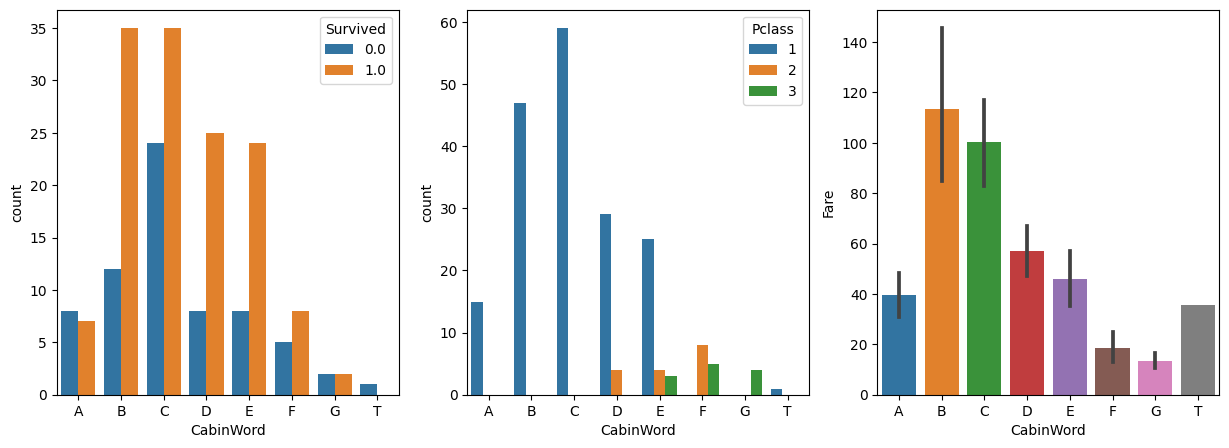

In [61]:
# Cabin
data['CabinWord'] = data['Cabin'].str.extract('([A-Za-z]+)', expand=False)

cabin_df = data[data['test'] == False]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(x='CabinWord', data=cabin_df.sort_values(by='CabinWord'), hue='Survived', ax=ax[0])
sns.countplot(x='CabinWord', data=cabin_df.sort_values(by='CabinWord'), hue='Pclass', ax=ax[1])
# add mean of age by cabin
sns.barplot(x='CabinWord', y='Fare', data=cabin_df.sort_values(by='CabinWord'), ax=ax[2])
plt.show()

def cabin_fillna(row):
    if not row['CabinWord']:
        return row['CabinWord']
    if row['Pclass'] == 1 and row['Fare'] > 100:
        return 'B'
    elif row['Pclass'] == 1 and row['Fare'] > 60:
        return 'C'
    elif row['Pclass'] == 1 and row['Fare'] > 50:
        return 'D'
    elif row['Pclass'] == 1:
        return 'E'
    elif row['Pclass'] == 2 and row['Fare'] > 50:
        return 'D'
    elif row['Pclass'] == 2 and row['Fare'] > 20:
        return 'E'
    elif row['Pclass'] == 2:
        return 'F'
    elif row['Pclass'] == 3 and row['Fare'] > 20:
        return 'E'
    elif row['Pclass'] == 3 and row['Fare'] > 15:
        return 'F'
    else:
        return 'G'
    
    
data['CabinWord'] = data.apply(cabin_fillna, axis=1)
cabin_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F':5, 'G':6, 'T':7}
data['CabinEncode'] = data['CabinWord'].map(cabin_map)
# maybe then important check number of cabin


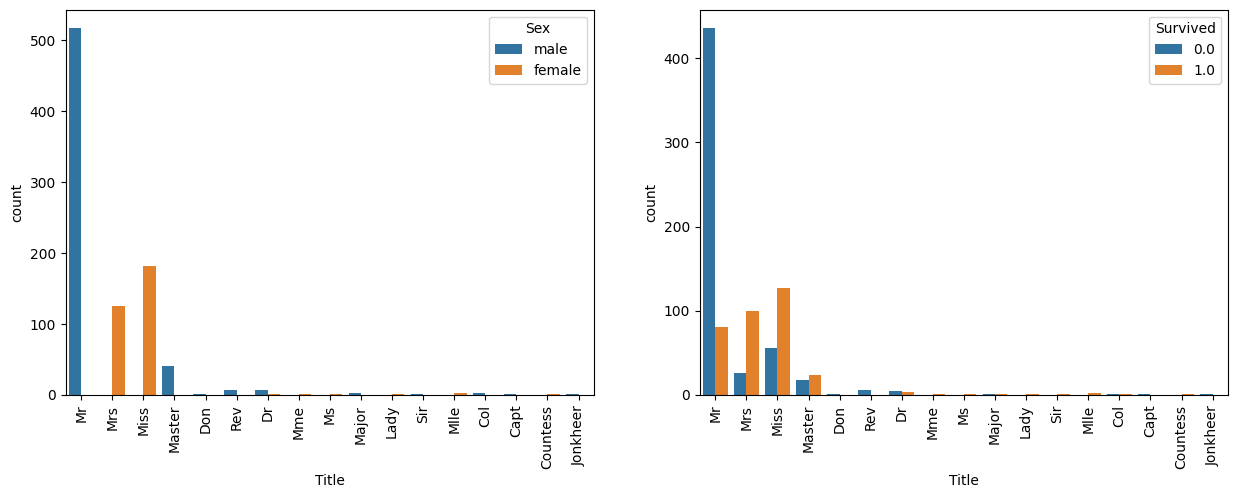

In [62]:
# Name
# person names
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
data['Title'].value_counts(dropna=False)
# graph
title_df = data[data['test'] == False]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# title vs Sex
sns.countplot(x='Title', data=title_df, hue='Sex', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

sns.countplot(x='Title', data=title_df, hue='Survived', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
plt.show()
# title encode
def title_encode(title):
    if title in ['Mrs', 'Ms', 'Mme', 'Lady', 'Mlle', 'Countess', 'Dona']:
        return 0
    elif title in ['Capt', 'Col', 'Major', 'Dr', 'Rev']:
        return 1
    else:
        return 2

data['TitleEncode'] = data['Title'].apply(title_encode)

In [63]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,FarePerPerson,FarePerClass,isAlone,Group,GroupAge,GroupAgeEncode,CabinWord,CabinEncode,Title,TitleEncode
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,3.62500,2.416667,False,0,Adult,2,G,6,Mr,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,35.64165,71.283300,False,1,Adult,2,C,2,Mrs,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,7.92500,2.641667,True,0,Adult,2,G,6,Miss,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,26.55000,53.100000,False,1,Adult,2,D,3,Mrs,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,8.05000,2.683333,True,0,Adult,2,G,6,Mr,2


In [64]:
data.pivot_table(index=['Sex'], columns=['Pclass'], values=['Survived'], aggfunc='mean')

Survived                    
Pclass         1         2         3
Sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447

In [65]:
data.pivot_table(index=['Sex'], columns=['Pclass', 'GroupAge'], values=['Survived'], aggfunc='mean')

Survived                                                        \
Pclass          1                                            2            
GroupAge    Child Teenager     Adult MiddleAge       Old Child Teenager   
Sex                                                                       
female        0.0      1.0  0.982456  0.958333  1.000000   1.0      1.0   
male          1.0      0.5  0.402985  0.342105  0.083333   1.0      0.0   

                                                                      \
Pclass                                         3                       
GroupAge     Adult MiddleAge       Old     Child  Teenager     Adult   
Sex                                                                    
female    0.918367  0.846154       NaN  0.478261  0.550000  0.532609   
male      0.083333  0.055556  0.333333  0.360000  0.076923  0.128302   

                         
Pclass                   
GroupAge MiddleAge  Old  
Sex                      
female    0.000000  1.0  
male      0.074074  0.0

In [89]:
data.pivot_table(index=['Sex'], columns=['Pclass', 'CabinWord'], values=['Survived'], aggfunc='mean')

Survived                                                       \
Pclass            1                                2                       
CabinWord         B         C       D         E    D         E         F   
Sex                                                                        
female     0.941176  1.000000  1.0000  0.916667  1.0  0.923077  0.914286   
male       0.368421  0.363636  0.4375  0.353846  0.0  0.205882  0.144928   

                                         
Pclass            3                      
CabinWord         E         F         G  
Sex                                      
female     0.243243  0.695652  0.559524  
male       0.183673  0.240000  0.117216

In [67]:
tf_features = ['Pclass', 'Age', 'GroupAgeEncode', 'Group', 'Fare', 'SexBin', 'EmbarkedEncode']
tf_data = data[tf_features]
tf_data.head()

,Pclass,Age,GroupAgeEncode,Group,Fare,SexBin,EmbarkedEncode
0,3,22.0,2,0,7.2500,0,0
1,1,38.0,2,1,71.2833,0,1
2,3,26.0,2,0,7.9250,0,0
3,1,35.0,2,1,53.1000,0,0
4,3,35.0,2,0,8.0500,0,0


In [68]:
# check missing values
tf_data.isna().sum(axis=0)

Pclass            0
Age               0
GroupAgeEncode    0
Group             0
Fare              0
SexBin            0
EmbarkedEncode    0
dtype: int64

In [69]:
X_train = data[~data['test']][tf_features]
X_test = data[data['test']][tf_features]

In [70]:
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)
# split train and cross validation
X_train, X_cv, y_train, y_cv = train_test_split(X_train, data_y, test_size=0.2)

In [71]:
# model with regularization
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [72]:
# train 
model.fit(X_train, y_train, epochs=400, validation_data=(X_train, y_train))

Epoch 1/400


23/23 [==============================] - 2s 15ms/step - loss: 1.0110 - accuracy: 0.6390 - val_loss: 0.9233 - val_accuracy: 0.6728
Epoch 2/400
23/23 [==============================] - 0s 4ms/step - loss: 0.8823 - accuracy: 0.6994 - val_loss: 0.8519 - val_accuracy: 0.7037
Epoch 3/400
23/23 [==============================] - 0s 4ms/step - loss: 0.8492 - accuracy: 0.6784 - val_loss: 0.8092 - val_accuracy: 0.7093
Epoch 4/400
23/23 [==============================] - 0s 4ms/step - loss: 0.8008 - accuracy: 0.7037 - val_loss: 0.7758 - val_accuracy: 0.7121
Epoch 5/400
23/23 [==============================] - 0s 4ms/step - loss: 0.7722 - accuracy: 0.7008 - val_loss: 0.7530 - val_accuracy: 0.7093
Epoch 6/400
23/23 [==============================] - 0s 4ms/step - loss: 0.7553 - accuracy: 0.7107 - val_loss: 0.7393 - val_accuracy: 0.6966
Epoch 7/400
23/23 [==============================] - 0s 4ms/step - loss: 0.7320 - accuracy: 0.7051 - val_loss: 0.7188 - val_accuracy: 0.7233
Epoch 8/400
23/23 [=====

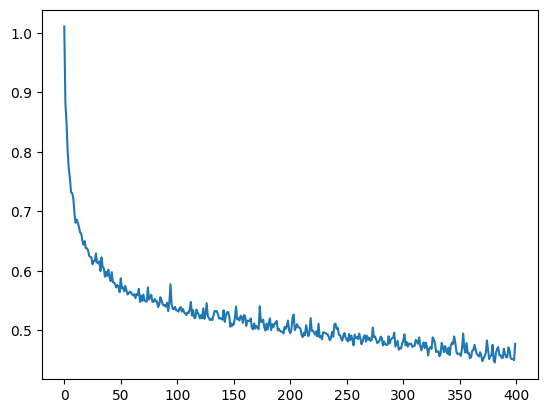

In [73]:
# graph loss
sns.lineplot(data=model.history.history['loss'])
plt.show()

In [74]:
# cross validation
cv = model.evaluate(X_cv, y_cv)
print('Cross validation loss: ', cv[0])

6/6 [==============================] - 0s 2ms/step - loss: 0.7048 - accuracy: 0.7151
Cross validation loss:  0.7047730684280396


In [75]:
# predict
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
y_pred.reshape(-1)

14/14 [==============================] - 0s 1ms/step


array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

In [76]:
# save to csv
submission = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': y_pred.reshape(-1)})
# File csv with 2 columns: PassengerId, Survived
submission.to_csv('data/submission.csv', index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


I have tried to use deep learning but I don't think it is the best model for this problem because the data is not enough. So I use random forest instead.

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [78]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,FarePerPerson,FarePerClass,isAlone,Group,GroupAge,GroupAgeEncode,CabinWord,CabinEncode,Title,TitleEncode
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,...,3.62500,2.416667,False,0,Adult,2,G,6,Mr,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,...,35.64165,71.283300,False,1,Adult,2,C,2,Mrs,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,...,7.92500,2.641667,True,0,Adult,2,G,6,Miss,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,...,26.55000,53.100000,False,1,Adult,2,D,3,Mrs,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,...,8.05000,2.683333,True,0,Adult,2,G,6,Mr,2
5,6,0.0,3,"Moran, Mr. James",male,28.218415,0,0,330877,8.4583,...,8.45830,2.819433,True,0,Adult,2,G,6,Mr,2
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,...,51.86250,51.862500,True,1,MiddleAge,3,D,3,Mr,2
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,...,4.21500,7.025000,False,0,Child,0,E,4,Master,2
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,...,3.71110,3.711100,False,0,Adult,2,G,6,Mrs,0
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,...,15.03540,15.035400,False,0,Teenager,1,E,4,Mrs,0


In [135]:
# split in train and cross validation

data["FarePerPerson"] = data["Fare"] / (data["SibSp"] + data["Parch"] + 1)
num_cols = ['Age', 'Fare', 'FarePerPerson', 'SibSp', 'Parch']
cat_cols = ['Pclass', 'SexBin', 'EmbarkedEncode', 'GroupAgeEncode', 'Group', 'CabinEncode', 'TitleEncode']

features = num_cols + cat_cols
X_train = data[~data['test']][features]
y_train = data_y
X_train, X_cv, y_train, y_cv = train_test_split(X_train, data_y, test_size=0.2)
X_test = data[data['test']][features]

In [170]:
# columns type

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ] 
)

In [182]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=0))
])
rf_model.set_params(classifier__max_depth=5)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Fare',
                                                   'FarePerPerson', 'SibSp',
                                                   'Parch']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Pclass', 'SexBin',
                                                   'EmbarkedEncode',
                                                   'GroupAgeEncode', 'Group',
                                                   'CabinEncode',
                                                   'TitleEncode'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, random_state=0))])

In [183]:
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Fare',
                                                   'FarePerPerson', 'SibSp',
                                                   'Parch']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Pclass', 'SexBin',
                                                   'EmbarkedEncode',
                                                   'GroupAgeEncode', 'Group',
                                                   'CabinEncode',
                                                   'TitleEncode'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, random_state=0))])

In [184]:
y_pred = rf_model.predict(X_train)
y_pred_cv = rf_model.predict(X_cv)
print('Accuracy: ', accuracy_score(y_train, y_pred))
print('Accuracy CV: ', accuracy_score(y_cv, y_pred_cv))

Accuracy:  0.797752808988764
Accuracy CV:  0.7877094972067039


In [185]:
pred = rf_model.predict(X_test)

In [186]:
# save to csv
submission = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': pred.reshape(-1)})
# File csv with 2 columns: PassengerId, Survived
submission.to_csv('data/submission_random_forest.csv', index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [196]:
param_grid = {
    'classifier__n_estimators': [10, 50, 100],
    'classifier__max_depth': [5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

In [197]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

In [198]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'FarePerPerson',
                                                                          'SibSp',
                                                                          'Parch']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Pclass',
                                                                          'SexBin',
                                                                          'EmbarkedEncode',
                                                                          'GroupAgeEncode',
                                                                          'Group',
                                                                          'CabinEncode',
                                                                          'TitleEncode'])])),
                                       ('classifier',
                                        RandomForestClassifier(max_depth=5,
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 10],
                         'classifier__max_features': ['auto', 'sqrt', 'log2'],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [10, 50, 100]},
             verbose=2)

In [199]:
y_pred = grid_search.predict(X_train)
y_pred_cv = grid_search.predict(X_cv)
print('Accuracy: ', accuracy_score(y_train, y_pred))
print('Accuracy CV: ', accuracy_score(y_cv, y_pred_cv))

Accuracy:  0.8525280898876404
Accuracy CV:  0.7597765363128491


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


model = KNeighborsClassifier(n_neighbors=5)
features =  ['Pclass', 'SexBin', 'EmbarkedEncode', 'GroupAgeEncode', 'Group', 'Age', 'Fare', 'TitleEncode']

X_train = data[~data['test']][features]
y_train = data_y
X_train, X_cv, y_train, y_cv = train_test_split(X_train, data_y, test_size=0.30)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
# cross validation
y_pred = model.predict(X_train)
y_cv = model.predict(X_cv)
print('Train accuracy: ', accuracy_score(y_train, y_pred))
print('Cross validation accuracy: ', accuracy_score(y_cv, y_cv))

In [ ]:
# save to csv
X_test = data[data['test']][features]
pred = model.predict(X_test)
pred_pd = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': pred.reshape(-1)})
pred_pd.to_csv('data/submission_knn.csv', index=False)
pred_pd.head()